# Detecção de anomalias

In [25]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import matplotlib.mlab as mlab
from scipy.io import loadmat  
from scipy import stats

In [26]:
data = loadmat('data/ex8data1.mat') 
X = data['X']
X_val = data['Xval']
y_val = data['yval']

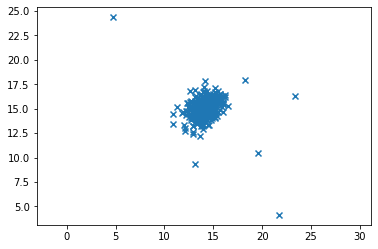

In [27]:
plt.scatter(X[:,0], X[:,1], marker='x')  
plt.axis('equal')
plt.show()

## Distribuição Gaussiana

## Estimativa de parâmetros para uma gaussiana

In [28]:
def estimate_gaussian_params(X):
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2

mu, sigma2 = estimate_gaussian_params(X)
print(mu)
print(sigma2)

[14.11222578 14.99771051]
[1.83263141 1.70974533]


In [29]:
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0, mux=0.0, muy=0.0, sigmaxy=0.0):
    Xmu = X - mux
    Ymu = Y - muy

    rho = sigmaxy / (sigmax * sigmay)
    z = Xmu ** 2 / sigmax ** 2 + Ymu ** 2 / sigmay ** 2 - 2 * rho * Xmu * Ymu / (sigmax * sigmay)
    denom = 2 * np.pi * sigmax * sigmay * np.sqrt(1 - rho ** 2)
    return np.exp(-z / (2 * (1 - rho ** 2))) / denom

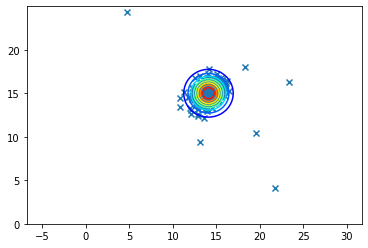

In [30]:
# Plot dataset and contour lines
plt.scatter(X[:,0], X[:,1], marker='x')  

x = np.arange(0, 25, .025)
y = np.arange(0, 25, .025)

first_axis, second_axis = np.meshgrid(x, y)

Z = bivariate_normal(first_axis, second_axis, np.sqrt(sigma2[0]), np.sqrt(sigma2[1]), mu[0], mu[1])

plt.contour(first_axis, second_axis, Z, 10, cmap=plt.cm.jet)
plt.axis('equal')
plt.show()

## Selecionando $\epsilon$

In [35]:
import warnings
#warnings.filterwarnings("error")

def select_epsilon(pval, yval):  
    best_epsilon_value = 0
    best_f1_value = 0
    step_size = (pval.max() - pval.min()) / 1000

    print('step size: ' + str(step_size))

    for epsilon in np.arange(pval.min(), pval.max(), step_size):
        preds = (pval < epsilon)[:, np.newaxis]
        
        tp = np.sum(preds[yval == 1] == 1)
        fp = np.sum(preds[yval == 0] == 1)
        fn = np.sum(preds[yval == 1] == 0)
        
        if tp == 0 and fp == 0:
            continue

        prec = tp / (tp + fp)    
        rec = tp / (tp + fn)
        
        F1 = (2 * prec * rec) / (prec + rec)
        if F1 > best_f1_value:
            best_f1_value = F1
            best_epsilon_value = epsilon
    return best_epsilon_value, best_f1_value

stddev = np.sqrt(sigma2)

pval = np.zeros((X_val.shape[0], X_val.shape[1]))  
pval[:,0] = stats.norm.pdf(X_val[:,0], mu[0], stddev[0])  
pval[:,1] = stats.norm.pdf(X_val[:,1], mu[1], stddev[1])  

print(np.prod(pval, axis=1).shape)

epsilon, _ = select_epsilon(np.prod(pval, axis=1), y_val.flatten())  

print('Best value found for epsilon: ' + str(epsilon))

(307,)
step size: 8.990852779269493e-05
Best value found for epsilon: 8.990852779269493e-05


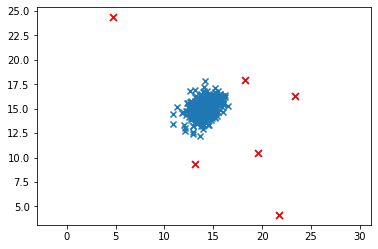

In [32]:
p = np.zeros((X.shape[0], X.shape[1]))  
p[:,0] = stats.norm.pdf(X[:,0], mu[0], stddev[0])  
p[:,1] = stats.norm.pdf(X[:,1], mu[1], stddev[1])

# Apply model to detect abnormal examples in X
anomalies = np.where(np.prod(p, axis=1) < epsilon)

# Plot the dataset X again, this time highlighting the abnormal examples.
plt.clf()
plt.scatter(X[:,0], X[:,1], marker='x')  
plt.scatter(X[anomalies[0],0], X[anomalies[0],1], s=50, color='r', marker='x')  
plt.axis('equal')
plt.show()